In [23]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from src import config

In [34]:
# 1. Load and Prepare Data
folder_path = config.GECKO_DATA_DIR
all_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

dataset_series = {}
for file in all_files:
    try:
        data = pd.read_csv(os.path.join(folder_path, file))
        
        # # Remove one the line which download by accident and is incomplete data
        # data['date'] = pd.to_datetime(data['date'])
        # data = data[data['date'].dt.time == pd.to_datetime('00:00:00').time()]
        # data.to_csv(os.path.join(folder_path, file))
        
        # Remove the last row which is often incomplete
        if not data.empty:
            data = data.iloc[:-1]

        data['Date'] = pd.to_datetime(data['date'])
        data = data.sort_values('Date').drop_duplicates(subset='Date')

        # Use 'market_cap' column
        price_series = pd.to_numeric(data['market_cap'])
        price_series.index = data['Date']

        file_name = file.replace('.csv', '')
        dataset_series[file_name] = price_series
    except Exception as e:
        print(f"Could not process file {file}: {e}")

# Merge all series into a single DataFrame
full_data = pd.concat(dataset_series, axis=1)

In [35]:
# print(dataset_series['bitcoin'])
print(full_data.shape)

(454, 1200)


In [4]:
print(pd.concat([dataset_series['bitcoin'], dataset_series['bityuan']], axis=1))

              market_cap    market_cap
Date                                  
2024-03-29  1.390870e+12           NaN
2024-03-30  1.374647e+12           NaN
2024-03-31  1.370247e+12           NaN
2024-04-01  1.401370e+12           NaN
2024-04-02  1.373784e+12           NaN
...                  ...           ...
2025-06-17  2.127895e+12  1.372241e+07
2025-06-18  2.080968e+12  1.369584e+07
2025-06-19  2.081678e+12  1.381322e+07
2025-06-20  2.081355e+12  1.377214e+07
2025-06-21  2.054120e+12  1.369184e+07

[452 rows x 2 columns]


In [13]:
print("\n--- Checking Series Lengths ---")

# Create a dictionary mapping each crypto name to the length of its series
lengths = {name: len(series) for name, series in dataset_series.items()}

# Convert the dictionary to a pandas Series for easy sorting and viewing
lengths_series = pd.Series(lengths)

# Sort the series in descending order to see the longest ones first
sorted_lengths = lengths_series.sort_values(ascending=False)

print("Top 10 longest data series:")
print(sorted_lengths)
print("-" * 30)


--- Checking Series Lengths ---
Top 10 longest data series:
arweave              454
api3                 454
akash-network        454
arpa                 454
aerodrome-finance    454
                    ... 
resolv-wstusr         60
anryton               57
onyx-arches           57
rcge                  24
moonrabbits           22
Length: 1200, dtype: int64
------------------------------


In [36]:
# Ensure the processed data directory exists
config.PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

# Save the newly created DataFrame to the cache file
full_data.to_csv(config.MARKET_CAP_FILE_PATH)

In [15]:
print(pd.read_csv(config.MARKET_CAP_FILE_PATH))

           Date      autonomi        rekt-4     goldfinch  tars-protocol  \
0    2024-03-29           NaN           NaN  2.748593e+08            NaN   
1    2024-03-30           NaN           NaN  2.613153e+08            NaN   
2    2024-03-31           NaN           NaN  2.684821e+08            NaN   
3    2024-04-01           NaN           NaN  3.595714e+08            NaN   
4    2024-04-02           NaN           NaN  3.948187e+08            NaN   
..          ...           ...           ...           ...            ...   
449  2025-06-21  3.288220e+07  1.261996e+08  6.175391e+07   4.774934e+07   
450  2025-06-22  3.194449e+07  1.166576e+08           NaN   4.259615e+07   
451  2025-06-23  3.349702e+07           NaN           NaN            NaN   
452  2025-06-24  3.254549e+07           NaN           NaN            NaN   
453  2025-06-25  3.301794e+07           NaN           NaN            NaN   

     chain-key-bitcoin         civic  qubic-network        dkargo  \
0         0.000000

In [25]:
def dynamic_index_base_py(dataframe: pd.DataFrame, m_start: float, tw: int = 30) -> pd.Series:
    """
    Calculates the index value for a single period using fixed PCA weights
    from the first half of the window, and chain-links the result.
    This is a direct translation of the new `dynamic_index_base_m_pre` R function.

    Args:
        dataframe (pd.DataFrame): The full data window for calculation (e.g., 60 days).
        m_start (float): The last index value from the previous period, used for linking.
        tw (int): The sub-window size for PCA calculation (defaults to 30).

    Returns:
        pd.Series: A pandas Series containing the calculated index values for the
                   second half of the window (e.g., the next 30 days).
    """
    # The logic requires a window of at least tw + 1 days to work.
    if len(dataframe) < tw + 1:
        return pd.Series(dtype=float)

    # --- Step 1: Perform PCA on the first `tw` days to get fixed weights ---
    pca_window = dataframe.iloc[0:tw]
    
    # Clean the PCA window just in case
    pca_window = pca_window.dropna(axis=1, how='any')
    if pca_window.shape[1] < 1: # check if any columns are left
        return pd.Series(dtype=float)

    scaler = StandardScaler()
    pca = PCA(n_components=1)
    
    scaled_data = scaler.fit_transform(pca_window)
    pca.fit(scaled_data)
    
    # Get the PC1 loadings (weights). Ensure consistent sign for stability.
    pc1_loadings = pca.components_[0]
    if np.sum(pc1_loadings) < 0:
        pc1_loadings = -pc1_loadings

    # Re-align loadings with the original dataframe's columns, filling missing with 0
    loadings_s = pd.Series(pc1_loadings, index=pca_window.columns)
    aligned_loadings = loadings_s.reindex(dataframe.columns, fill_value=0.0).values
        
    # --- Step 2: Calculate `a_base` for normalization ---
    # `a_base` is calculated using the data from the next day (day `tw`+1, or index `tw`)
    base_value_row = dataframe.iloc[tw]
    a_base = base_value_row.dot(aligned_loadings)
    
    # Avoid division by zero
    if a_base == 0:
        return pd.Series(dtype=float)

    # --- Step 3: Calculate index values for the second half of the window ---
    # This is the period for which we are actually calculating the index (e.g., days 31-60)
    index_calc_window = dataframe.iloc[tw:]
    
    # The first value of our new index segment is `m_start` (from the previous period)
    # This corresponds to the first day of the index_calc_window
    
    # Calculate the raw values for the rest of the window (from day 2 onwards)
    # This corresponds to R's `as.matrix(...) %*% ...`
    raw_values = index_calc_window.iloc[1:].dot(aligned_loadings)
    
    # Chain-link the values using the R formula: (raw_value * m) / a_base
    linked_values = (raw_values * m_start) / a_base
    
    # Combine the first value `m` with the rest of the linked values
    final_values = [m_start] + linked_values.tolist()
    
    # --- Step 4: Create the final DataFrame segment ---
    result_series = pd.Series(
        final_values, 
        index=index_calc_window.index, 
        name='Value'
    )
    
    return result_series

In [29]:
# test data
data_test = full_data.iloc[0:60,].dropna(axis = 1)
print(len(data_test))
# print(data_test.head())
test_result = dynamic_index_base_py(data_test, m_start= 1000)
print(test_result)
print(len(test_result))

60
Date
2024-04-28    1000.000000
2024-04-29     993.682044
2024-04-30     997.717091
2024-05-01     943.001622
2024-05-02     922.029035
2024-05-03     929.129152
2024-05-04     985.536145
2024-05-05     996.362728
2024-05-06    1000.270672
2024-05-07     987.761751
2024-05-08     972.165484
2024-05-09     951.626951
2024-05-10     982.010785
2024-05-11     944.783240
2024-05-12     942.453754
2024-05-13     949.857683
2024-05-14     965.407234
2024-05-15     941.466037
2024-05-16    1014.875285
2024-05-17     996.317248
2024-05-18    1030.620588
2024-05-19    1033.726819
2024-05-20    1015.852428
2024-05-21    1125.660505
2024-05-22    1123.294295
2024-05-23    1106.034330
2024-05-24    1090.785329
2024-05-25    1094.194700
2024-05-26    1105.476868
2024-05-27    1099.601509
Freq: D, Name: Value, dtype: float64
30


In [30]:
def dynamic_index_base_py(dataframe: pd.DataFrame, m_start: float, tw: int = 30) -> pd.Series:
    """
    Calculates the index value for a single period using fixed PCA weights
    from the first half of the window, and chain-links the result.
    This is a direct translation of the new `dynamic_index_base_m_pre` R function.

    Args:
        dataframe (pd.DataFrame): The full data window for calculation (e.g., 60 days).
        m_start (float): The last index value from the previous period, used for linking.
        tw (int): The sub-window size for PCA calculation (defaults to 30).

    Returns:
        pd.Series: A pandas Series containing the calculated index values for the
                   second half of the window (e.g., the next 30 days).
    """
    # The logic requires a window of at least tw + 1 days to work.
    if len(dataframe) < tw + 1:
        return pd.Series(dtype=float)

    # --- Step 1: Perform PCA on the first `tw` days to get fixed weights ---
    pca_window = dataframe.iloc[0:tw]
    
    # Clean the PCA window just in case
    pca_window = pca_window.dropna(axis=1, how='any')
    if pca_window.shape[1] < 1: # check if any columns are left
        return pd.Series(dtype=float)

    scaler = StandardScaler()
    pca = PCA(n_components=1)
    
    scaled_data = scaler.fit_transform(pca_window)
    pca.fit(scaled_data)
    
    # Get the PC1 loadings (weights). Ensure consistent sign for stability.
    pc1_loadings = pca.components_[0]
    if np.sum(pc1_loadings) < 0:
        pc1_loadings = -pc1_loadings

    # Re-align loadings with the original dataframe's columns, filling missing with 0
    loadings_s = pd.Series(pc1_loadings, index=pca_window.columns)
    aligned_loadings = loadings_s.reindex(dataframe.columns, fill_value=0.0).values
        
    # --- Step 2: Calculate `a_base` for normalization ---
    # `a_base` is calculated using the data from the next day (day `tw`+1, or index `tw`)
    base_value_row = dataframe.iloc[tw]
    a_base = base_value_row.dot(aligned_loadings)
    
    # Avoid division by zero
    if a_base == 0:
        return pd.Series(dtype=float)

    # --- Step 3: Calculate index values for the second half of the window ---
    # This is the period for which we are actually calculating the index (e.g., days 31-60)
    index_calc_window = dataframe.iloc[tw:]
    
    # The first value of our new index segment is `m_start` (from the previous period)
    # This corresponds to the first day of the index_calc_window
    
    # Calculate the raw values for the rest of the window (from day 2 onwards)
    # This corresponds to R's `as.matrix(...) %*% ...`
    raw_values = index_calc_window.dot(aligned_loadings)
    
    # Chain-link the values using the R formula: (raw_value * m) / a_base
    final_values = (raw_values * m_start) / a_base
    
    # --- Step 4: Create the final DataFrame segment ---
    result_series = pd.Series(
        final_values, 
        index=index_calc_window.index, 
        name='Value'
    )
    
    return result_series

In [33]:
test_result = dynamic_index_base_py(data_test, m_start= 1000)
print(test_result)
print(len(test_result))

Date
2024-04-28    1000.000000
2024-04-29     993.682044
2024-04-30     997.717091
2024-05-01     943.001622
2024-05-02     922.029035
2024-05-03     929.129152
2024-05-04     985.536145
2024-05-05     996.362728
2024-05-06    1000.270672
2024-05-07     987.761751
2024-05-08     972.165484
2024-05-09     951.626951
2024-05-10     982.010785
2024-05-11     944.783240
2024-05-12     942.453754
2024-05-13     949.857683
2024-05-14     965.407234
2024-05-15     941.466037
2024-05-16    1014.875285
2024-05-17     996.317248
2024-05-18    1030.620588
2024-05-19    1033.726819
2024-05-20    1015.852428
2024-05-21    1125.660505
2024-05-22    1123.294295
2024-05-23    1106.034330
2024-05-24    1090.785329
2024-05-25    1094.194700
2024-05-26    1105.476868
2024-05-27    1099.601509
Freq: D, Name: Value, dtype: float64
30


In [32]:
def dynamic_index_base_py(dataframe: pd.DataFrame, m_start: float, tw: int = 30) -> pd.Series:
    """
    Calculates the index value for a single period using fixed PCA weights
    from the first half of the window, and chain-links the result.
    This version incorporates the user's more efficient vectorization.

    Args:
        dataframe (pd.DataFrame): The full data window for calculation (e.g., 60 days).
        m_start (float): The last index value from the previous period, used for linking.
        tw (int): The sub-window size for PCA calculation (defaults to 30).

    Returns:
        pd.Series: A pandas Series containing the calculated index values for the
                   second half of the window (e.g., the next 30 days).
    """
    if len(dataframe) < tw + 1:
        return pd.Series(dtype=float)

    # --- Step 1: Perform PCA on the first `tw` days to get fixed weights ---
    pca_window = dataframe.iloc[0:tw].dropna(axis=1, how='any')
    if pca_window.shape[1] < 1:
        return pd.Series(dtype=float)

    scaler = StandardScaler()
    pca = PCA(n_components=1)
    scaled_data = scaler.fit_transform(pca_window)
    pca.fit(scaled_data)
    
    pc1_loadings = pca.components_[0]
    if np.sum(pc1_loadings) < 0:
        pc1_loadings = -pc1_loadings

    loadings_s = pd.Series(pc1_loadings, index=pca_window.columns)
    aligned_loadings = loadings_s.reindex(dataframe.columns, fill_value=0.0).values
        
    # --- Step 2: Calculate `a_base` for normalization ---
    base_value_row = dataframe.iloc[tw]
    a_base = base_value_row.dot(aligned_loadings)
    
    if a_base == 0:
        return pd.Series(dtype=float)

    # --- Step 3: Calculate index values for the second half of the window ---
    index_calc_window = dataframe.iloc[tw:]
    
    # Calculate the raw values for the entire calculation window
    raw_values = index_calc_window.dot(aligned_loadings)
    
    # Chain-link all values in a single vectorized operation
    final_values = (raw_values * m_start) / a_base
    
    # Create the final Series. The name and index are already aligned.
    final_values.name = 'Value'
    
    return final_values

---
### **Part 2: Comparative Analysis - Change of the Index Calculation Variables(Tn, Tw,...)**

To find out a better index for better interpretability, we need to construct a better index which can capture more movement of the market and has better r-squared in model fitting process than the original market capitalization.

In [18]:
def nc_cal_py(dataframe: pd.DataFrame, threshold: float = config.VARIANCE_THRESHOLD) -> dict:
    """
    Determines the number of assets (Nc) to include by finding the smallest
    subset of top assets whose index correlates highly with a "full" index.
    This is a direct translation of the user's R code logic.

    Args:
        dataframe (pd.DataFrame): DataFrame of market caps for a time window.
                                  (Assumes columns are pre-sorted by market cap).
        threshold (float): The correlation threshold to meet (e.g., 0.99).

    Returns:
        dict: A dictionary containing Nc and the list of chosen crypto names.
    """
    num_assets = dataframe.shape[1]

    # This logic requires at least 2 assets to compare.
    if num_assets < 2:
        return {
            "Nc": num_assets,
            "Choosen Crypto": dataframe.columns.tolist()
        }

    # --- Step 1 & 2: Loop through subsets and calculate PC1 index for each ---
    index_series_list = []
    scaler = StandardScaler()

    # The loop starts at 2, creating indices for the top 2, top 3, ..., top N assets
    for i in range(2, num_assets + 1):
        subset_data = dataframe.iloc[:, :i]

        # Scale the data and perform PCA
        scaled_subset = scaler.fit_transform(subset_data)
        pca = PCA(n_components=1)
        pca.fit(scaled_subset)

        # Get PC1 loadings (weights). Ensure consistent direction.
        pc1_loadings = pca.components_[0]
        if np.sum(pc1_loadings) < 0:
            pc1_loadings = -pc1_loadings

        # Calculate the index for this subset (Matrix multiplication)
        # This is equivalent to R's `%*%` operator
        subset_index = subset_data.dot(pc1_loadings)
        index_series_list.append(subset_index)

    # --- Step 3: Calculate Correlations against the "full" index ---
    # The benchmark index is the last one calculated, which used all available assets.
    benchmark_index = index_series_list[-1]

    correlations = []
    for subset_idx in index_series_list:
        # Note: The correlation of the last index with itself will be 1.0
        corr = subset_idx.corr(benchmark_index)
        correlations.append(corr)

    # --- Step 4: Find the first index that meets the correlation threshold ---
    correlations = np.array(correlations)

    # `np.where` finds the indices where the condition is true. We take the first one.
    indices_reaching_threshold = np.where(correlations >= threshold)[0]

    if len(indices_reaching_threshold) > 0:
        # The first element in `correlations` corresponds to an index of 2 assets.
        # So, we add 2 to the found list index to get the true number of assets.
        first_reach_list_index = indices_reaching_threshold[0]
        nc = first_reach_list_index + 2
    else:
        # If no subset meets the threshold, use all assets as a fallback.
        nc = num_assets

    chosen_crypto_list = dataframe.columns[:nc].tolist()

    time_window = [str(dataframe.index[0]), str(dataframe.index[-1])]
    # The main script only needs 'Nc' and 'Choosen Crypto'.
    # We return these in the expected dictionary format.
    return {
        "Nc": int(nc),
        "Choosen Crypto": chosen_crypto_list,
        "Time Window": time_window
    }

def dynamic_index_base_py(dataframe: pd.DataFrame, m_start: float, tw: int = 30) -> pd.Series:
    """
    Calculates the index value for a single period using fixed PCA weights
    from the first half of the window, and chain-links the result.
    This version incorporates the user's more efficient vectorization.

    Args:
        dataframe (pd.DataFrame): The full data window for calculation (e.g., 60 days).
        m_start (float): The last index value from the previous period, used for linking.
        tw (int): The sub-window size for PCA calculation (defaults to 30).

    Returns:
        pd.Series: A pandas Series containing the calculated index values for the
                   second half of the window (e.g., the next 30 days).
    """
    if len(dataframe) < tw + 1:
        return pd.Series(dtype=float)

    # --- Step 1: Prepare the PCA window and scaler ---
    pca_window = dataframe.iloc[0:tw].dropna(axis=1, how='any')
    scaler = StandardScaler()
    
    # --- Step 2: Hierarchical PCA Weight Calculation ---
    num_assets = pca_window.shape[1]
    
    if num_assets >= 3:
        # Primary method: Use 3 principal components
        n_components = 3
        pca = PCA(n_components=n_components)
        scaled_data = scaler.fit_transform(pca_window)
        pca.fit(scaled_data)
        
        explained_variances = pca.explained_variance_ratio_
        loadings = pca.components_
        
        # Combine weights from all 3 components, weighted by their explained variance
        combined_weights = np.dot(explained_variances, loadings)
        
    elif num_assets == 2:
        # Fallback 1: Use 2 principal components
        n_components = 2
        pca = PCA(n_components=n_components)
        scaled_data = scaler.fit_transform(pca_window)
        pca.fit(scaled_data)
        
        explained_variances = pca.explained_variance_ratio_
        loadings = pca.components_
        
        # Combine weights from 2 components
        combined_weights = np.dot(explained_variances, loadings)
        
    elif num_assets == 1:
        # Fallback 2: Original method with 1 component
        # The first principal component of a single variable is just the variable itself (weight=1)
        combined_weights = np.array([1.0])
        
    else:
        # Exit condition: Not enough data to form an index
        return pd.Series(dtype=float)

    # --- Step 3: Normalize weights and align with full dataframe ---
    # Normalizing by the sum of absolute values handles positive/negative weights.
    final_weights = combined_weights / np.sum(np.abs(combined_weights))

    loadings_s = pd.Series(final_weights, index=pca_window.columns)
    aligned_loadings = loadings_s.reindex(dataframe.columns, fill_value=0.0).values
        
    # --- Step 4: Calculate the index value (this part remains the same) ---
    base_value_row = dataframe.iloc[tw]
    a_base = base_value_row.dot(aligned_loadings)
    
    if a_base == 0:
        return pd.Series(dtype=float)

    index_calc_window = dataframe.iloc[tw:]
    raw_values = index_calc_window.dot(aligned_loadings)
    final_values = (raw_values * m_start) / a_base
    final_values.name = 'Value'
    
    return final_values

def dynamic_index_cal_py(dataframe: pd.DataFrame, tn: int = 90, tn_gap: int = 30, tw: int = 30,
                         threshold: float = 0.99) -> list:
    """
    The main function to calculate the dynamic index.

    Args:
        dataframe (pd.DataFrame): The full DataFrame of market caps.
        tn (int): The length of the look-back period for choosing components (e.g., 90 days).
        tn_gap (int): The step size for each iteration (e.g., 30 days).
        tw (int): The length of the index calculation window (e.g., 30 days - although the R code uses 60).
                  Note: The R code slices `31:90`, which is 60 days. We use `Tw = 60`.
        threshold (float): Variance threshold for component selection.

    Returns:
        list: A list containing [list_of_nc_results, list_of_index_series].
    """

    # --- Nc Choosing process ---
    nc_results = []
    n_iter = (len(dataframe) - tn) // tn_gap

    print("Starting Nc (Number of Components) selection process...")
    for i in range(n_iter + 1):
        start_row = i * tn_gap
        end_row = tn + i * tn_gap

        # Slice the 90-day window
        data_90 = dataframe.iloc[start_row:end_row].copy()

        # Data filtering pipeline, similar to R's `select(where(...))`
        # Drop columns that contain any NA or 0 values
        data_90 = data_90.loc[:, (data_90.notna().all() & (data_90 != 0).all())]
        # Drop columns with zero standard deviation
        valid_std = data_90.std() > 0
        data_90 = data_90.loc[:, valid_std]

        if data_90.empty:
            continue

        # Sort columns by the first row's market cap, descending
        sorted_cols = data_90.iloc[0].sort_values(ascending=False).index
        data_90 = data_90[sorted_cols]

        nc_results.append(nc_cal_py(data_90, threshold=threshold))
        print(
            f"  Iteration {i + 1}/{n_iter + 1}: Found {nc_results[-1]['Nc']} components from {len(nc_results[-1]['Choosen Crypto'])} cryptos.")

    # --- Dynamic Index Calculation ---
    dynamic_index_results = []
    m = 1000.0  # Start the index at 1000 for better scaling

    print("\nStarting Dynamic Index calculation...")
    for i, nc_info in enumerate(nc_results):
        # The calculation window starts 30 days into the 90-day selection window
        start_row_60 = i * tn_gap + (tn - tw)
        end_row_60 = (tn + tw) + i * tn_gap

        # Select the 60-day window
        data_60 = dataframe.iloc[start_row_60:end_row_60].copy()

        # Filter by selected cryptos from the Nc process
        chosen_cryptos = [c for c in nc_info["Choosen Crypto"] if c in data_60.columns]
        data_60 = data_60[chosen_cryptos]

        # Further clean this specific window
        data_60 = data_60.loc[:, (data_60.notna().all() & (data_60 != 0).all())]

        if len(data_60) < (tn - tw) or data_60.shape[1] < 1:
            print(f"  Skipping Iteration {i + 1}: Not enough valid data for index calculation.")
            continue

        index_segment = dynamic_index_base_py(data_60, m_start = m, tw=tw)

        if not index_segment.empty:
            dynamic_index_results.append(index_segment)
            # Update 'm' to the last value of the newly calculated segment
            m = index_segment.iloc[-1]
            print(f"  Iteration {i + 1}: Calculated index segment. New base value m = {m:.2f}")

    return [nc_results, dynamic_index_results]

In [19]:
# 2. Calculate the Dynamic Index
market_cap_full_data = pd.read_csv(config.MARKET_CAP_FILE_PATH, index_col='Date', parse_dates=True)

nc_res, index_res = dynamic_index_cal_py(market_cap_full_data, )

output_index = pd.concat(index_res)

Starting Nc (Number of Components) selection process...
  Iteration 1/13: Found 197 components from 197 cryptos.
  Iteration 2/13: Found 114 components from 114 cryptos.
  Iteration 3/13: Found 2 components from 2 cryptos.
  Iteration 4/13: Found 3 components from 3 cryptos.
  Iteration 5/13: Found 4 components from 4 cryptos.
  Iteration 6/13: Found 2 components from 2 cryptos.
  Iteration 7/13: Found 2 components from 2 cryptos.
  Iteration 8/13: Found 2 components from 2 cryptos.
  Iteration 9/13: Found 57 components from 57 cryptos.
  Iteration 10/13: Found 28 components from 28 cryptos.
  Iteration 11/13: Found 2 components from 2 cryptos.
  Iteration 12/13: Found 10 components from 10 cryptos.
  Iteration 13/13: Found 2 components from 2 cryptos.

Starting Dynamic Index calculation...
  Iteration 1: Calculated index segment. New base value m = 1058.99
  Iteration 2: Calculated index segment. New base value m = 965.93
  Iteration 3: Calculated index segment. New base value m = 982

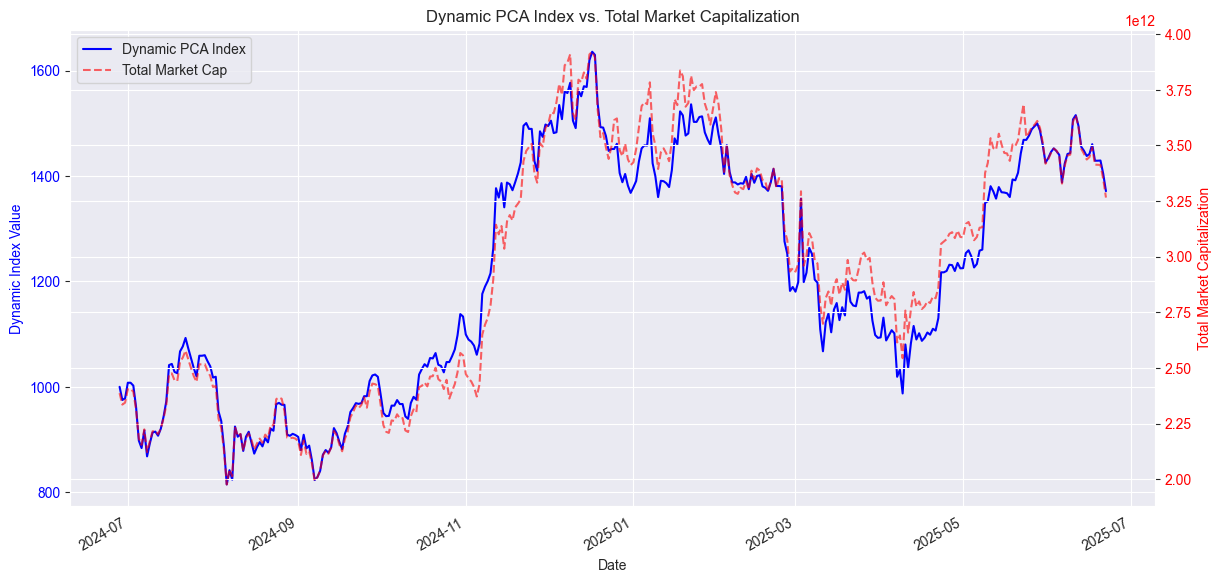

In [20]:
# 3. Combine and Plot Results
if index_res:
    # Combine all the index segments into one continuous series
    combined_dynamic_index = pd.concat(index_res)
    # Remove any duplicate index entries that might occur at the seams
    combined_dynamic_index = combined_dynamic_index[~combined_dynamic_index.index.duplicated(keep='first')]

    # For comparison, calculate the total market capitalization
    total_market_cap = market_cap_full_data.sum(axis=1)

    # Align the total market cap data with the index data
    aligned_market_cap = total_market_cap.reindex(combined_dynamic_index.index)

    # Plotting
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot Dynamic Index on the left y-axis
    ax1.plot(combined_dynamic_index.index, combined_dynamic_index, color='blue', label='Dynamic PCA Index')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Dynamic Index Value', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True)

    # Create a second y-axis for the total market capitalization
    ax2 = ax1.twinx()
    ax2.plot(aligned_market_cap.index, aligned_market_cap, color='red', alpha=0.6, linestyle='--',
             label='Total Market Cap')
    ax2.set_ylabel('Total Market Capitalization', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Formatting and Legends
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    fig.autofmt_xdate()
    plt.title('Dynamic PCA Index vs. Total Market Capitalization')

    # Combine legends from both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.show()
else:
    print("Could not generate index results. The dataset might be too sparse or short.")

In [21]:
output_index.to_csv("../data/processed/dynamic_pca_index_new.csv")

--- Analyzing Explained Variance of Principal Components ---
Loaded market cap data with shape: (454, 1200)
Shape after cleaning NaNs for PCA: (324, 826)

Explained Variance of PC1: 48.35%
Explained Variance of PC2: 22.27%
Explained Variance of PC3: 9.21%


/var/folders/17/h1jp6fwn2hgbggdw80lqlsz40000gn/T/ipykernel_52713/2198572846.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_pca.dropna(axis=0, inplace=True)


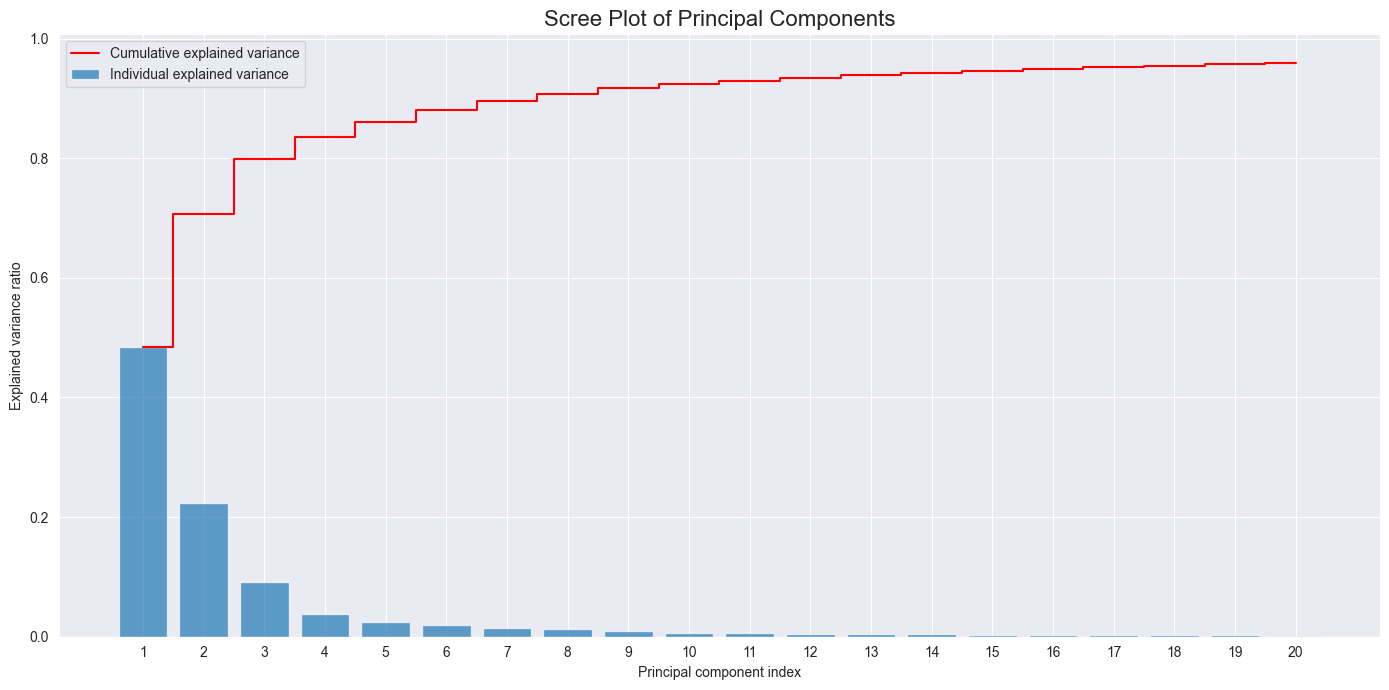

In [22]:
# Cell: Diagnostic - Analyzing PCA Explained Variance

print("--- Analyzing Explained Variance of Principal Components ---")

# 1. Load the full market cap data
try:
    full_data = pd.read_csv(config.MARKET_CAP_FILE_PATH, index_col='Date', parse_dates=True)
    print(f"Loaded market cap data with shape: {full_data.shape}")
except FileNotFoundError as e:
    print(f"ERROR: Missing data file: {e.filename}")

# 2. Prepare data for a static PCA
# For this analysis, we need a complete matrix (no NaN values).
# We'll keep assets that have at least 95% of the data points and then drop any days with remaining NaNs.
data_for_pca = full_data.dropna(axis=1, thresh=len(full_data) * 0.95)
data_for_pca.dropna(axis=0, inplace=True)

print(f"Shape after cleaning NaNs for PCA: {data_for_pca.shape}")

# 3. Scale the data (essential for PCA)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_pca)

# 4. Perform PCA
pca = PCA()
pca.fit(scaled_data)

# 5. Analyze and Display the Results
explained_variance = pca.explained_variance_ratio_

print(f"\nExplained Variance of PC1: {explained_variance[0]:.2%}")
print(f"Explained Variance of PC2: {explained_variance[1]:.2%}")
print(f"Explained Variance of PC3: {explained_variance[2]:.2%}")

# --- Plot the Explained Variance (Scree Plot) ---
plt.figure(figsize=(14, 7))

# Plot the variance of each component
plt.bar(range(1, 21), explained_variance[:20], alpha=0.7, align='center',
        label='Individual explained variance')
plt.step(range(1, 21), np.cumsum(explained_variance[:20]), where='mid',
         label='Cumulative explained variance', color='red')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.xticks(range(1, 21))
plt.legend(loc='best')
plt.title('Scree Plot of Principal Components', fontsize=16)
plt.tight_layout()
plt.show()

# Try supply calculation

In [24]:
import requests
import pandas as pd

# Get top 30 coins by market cap
url = 'https://api.coingecko.com/api/v3/coins/markets'
params = {
    'vs_currency': 'usd',
    'order': 'market_cap_desc',
    'per_page': 30,
    'page': 1,
    'sparkline': 'false'
}

response = requests.get(url, params=params)
data = response.json()

# Extract relevant supply info
coins = pd.DataFrame([{
    'id': c['id'],
    'symbol': c['symbol'],
    'name': c['name'],
    'circulating_supply': c.get('circulating_supply'),
    'total_supply': c.get('total_supply'),
    'max_supply': c.get('max_supply')
} for c in data])

print(coins.head())

# Save to JSON if needed
# coins.to_json("top30_crypto_supply.json", orient='records', indent=4)


/Users/zacharyvonc/Documents/UCLA/MASDS Thesis/PCA_Index/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


            id symbol      name  circulating_supply  total_supply  \
0      bitcoin    btc   Bitcoin        1.989291e+07  1.989291e+07   
1     ethereum    eth  Ethereum        1.207145e+08  1.207145e+08   
2       ripple    xrp       XRP        5.913163e+10  9.998595e+10   
3       tether   usdt    Tether        1.598869e+11  1.598869e+11   
4  binancecoin    bnb       BNB        1.458876e+08  1.458876e+08   

     max_supply  
0  2.100000e+07  
1           NaN  
2  1.000000e+11  
3           NaN  
4  2.000000e+08  
